# How to use Javascript D3 in Python Jupyter Notebook

### Requirements:

* HTML code to create DOM in Notebook:  e.g. initialize vis UI
* Javascript code to manipulate HTML Notebook DOM:  e.g. update vis
* Javascript query to Python:  e.g. user interaction callback
* Python query to Javascript:  e.g. initialize visualization
* Import D3 library in Javascript

In [5]:
from IPython.display import display, HTML, Javascript
import json

## Write HTML in Jupyter

Use Jupyter **%%html** magics:
* https://ipython.readthedocs.io/en/stable/interactive/magics.html
* https://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb


In [81]:
%%html
<p> Here is my button: 
<button id='hello'>Hello World</button>

###  Python send data to HTML
Use **IPython.display.HTML( )**.

In [ ]:
from IPython.display import HTML
#from IPython.core.display import HTML, display

In [86]:
mydict = {'hello':1, 'world':2}
mydict

{'hello': 1, 'world': 2}

In [ ]:
# Data-driven HTML
HTML("<button>Hello World " + str(mydict) + "</button>")

## Write Javascript in Jupyter

Use Jupyter **%%javascript** or **%%js** magics to run javascript in the browser.  Javascript code has access to global **document** and **window** objects.  Local variables do not persist.  Use **window.var** to store persistent data.  **element** is the output cell.

In [83]:
%%js
//# Global data storage
window.mydata = "FOOBAR"

<IPython.core.display.Javascript object>

In [ ]:
%%js
console.log(window.mydata)
document.getElementById('hello').textContent = window.mydata

In [84]:
%%js
element.append("Hello")

<IPython.core.display.Javascript object>

###  Python send data to Javascript

In Python, use **IPython.display.Javascript( )** and **json.dumps( )** .  Can use only 1 Javascript( ) call per cell and the cell cannot output anything.
* https://blog.thedataincubator.com/2015/08/embedding-d3-in-an-ipython-notebook/
* https://github.com/cmoscardi/embedded_d3_example/blob/master/Embedded_D3.ipynb

In [87]:
from IPython.display import Javascript
import json

In [ ]:
json.dumps(mydict)

In [88]:
# run arbitrary javascript, client-side
# transmit data in json string format
Javascript('window.mydata = ' + json.dumps(mydict) + '; console.log(window.mydata);')

<IPython.core.display.Javascript object>

In [ ]:
%%js
# use the data in js
document.getElementById('hello').textContent = window.mydata['hello']

In [ ]:
# Data size limitations, makes the ipynb file very large, can crash the kernel
Javascript('window.mydata = ' + json.dumps(list(range(1000000))) + '; console.log(window.mydata);')

In [ ]:
list(range(1000000))

###  Javascript send data to Python

In Javascript, use **IPython.notebook.kernel.execute( )** and **JSON.stringify( )**.

https://jakevdp.github.io/blog/2013/06/01/ipython-notebook-javascript-python-communication/
 

In [89]:
%%js
// transmit data in json string form
IPython.notebook.kernel.execute('somedata = ' + JSON.stringify(window.mydata))

<IPython.core.display.Javascript object>

In [90]:
somedata

{'hello': 1, 'world': 2}

###  Javascript send data to Python and get return data to Javascript

https://gist.github.com/sanbor/e9c8b57c5759d1ff382a

This would be useful for interactive input in tools like Andromeda.

In [ ]:
%%js
function callback(out){
    // Parse JSON output from python.  eval() strips the outer quotes.
    console.log(JSON.parse(eval(out.content.data["text/plain"])))
}
IPython.notebook.kernel.execute('json.dumps(mydict)', {'iopub':{'output': callback}}, {'silent':false})


### Python to Javascript back to Python

No obvious way to get a return value from Javascript?  Probably need to nest the methods like:
<pre> Javascript('kernel.execute(...)') </pre>

This might be useful for data science updates or Active Learning scenarios.


# D3 Example

Pandas, sklearn

In [1]:
# Use pandas to read data
import pandas
table = pandas.read_csv('Animal_Data_study_sorted.csv')
table = table.set_index('Animal')
table.head()

# Use sklearn to process data
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2)
table2D = pandas.DataFrame(mds.fit_transform(table), columns=['x','y'], index=table.index)
table2D['Name'] = table2D.index
table2D.head()

,x,y,Name
Animal,,,
Bat,145.949264,194.742008,Bat
Beaver,-136.902395,10.253041,Beaver
Blue Whale,-170.638250,-177.162565,Blue Whale
Bobcat,-10.490797,182.170127,Bobcat
Buffalo,24.039446,-136.822998,Buffalo


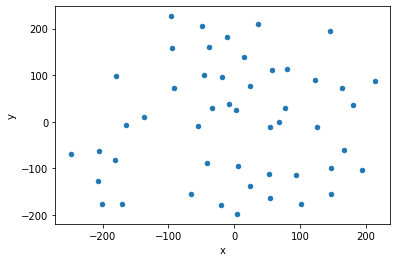

In [3]:
# Matplotlib sucks
%matplotlib inline
table2D.plot.scatter(x='x', y='y')

In [ ]:
table2D.to_dict(orient='records')

In [6]:
# Send processed data to Javascript:
Javascript('window.d3data=' + json.dumps(table2D.to_dict(orient='records')) )

<IPython.core.display.Javascript object>

### Import D3 into Javascript globally

https://stackoverflow.com/questions/45714017/d3-js-loading-version-3-vs-version-4-in-jupyter-notebook

Finicky, need to clear all output and restart the notebook if you want to make changes.
Is there a way to "unrequire" to enable changing the D3 version?

In [7]:
%%javascript
// Import D3, forces D3 to load and provide global access

//require.config({paths: {d3: 'https://d3js.org/d3.v3'} });
require.config({paths: {d3: 'https://d3js.org/d3.v5'} });

require(['d3'], function(d3) { window.d3 = d3; });


<IPython.core.display.Javascript object>

In [8]:
%%html
<!-- Create the SVG box for D3 -->
<svg id="svg1" width="500" height="300" style="border:1px solid black">
	<text id="tooltip" x="50" y="50">Mouseover</text>
</svg>
<p id="details">Click for details</p>

In [9]:
%%js
//# standard D3 stuff.  use window.d3data that was transmitted from python.

var scalex = d3.scaleLinear().domain([-400, 400]).range([0, 500]);
var scaley = d3.scaleLinear().domain([-400, 400]).range([300, 0]);

//# Make scatterplot:
var circles = d3.select("#svg1").selectAll("circle")
	.data(window.d3data) 	// bind the data to the circles.
	.enter()		        // for data that does not have an existing circle,
	.append("circle");		// make a new circle.
//# Update scatterplot (can re-run when making changes):
d3.select("#svg1").selectAll("circle")
	.attr("cx", d => scalex(d.x))	// d=bound data; i=index
	.attr("cy", d => scaley(d.y))
	.attr("r", 7)
    .style("fill", "steelblue")
    .style("opacity", "0.75")
    .on("mouseover", function(d,i) {
		d3.select(this).style("fill", "orange");
		d3.select("#tooltip").html(d.Name); } )
	.on("mouseout", function(d,i) {
		d3.select(this).style("fill", "steelblue"); } )
    //# on click, roundtrip to python to retrieve detail data values:
    .on("click", function(d,i) {
        function callback(out){
            d3.select("#details").html(out.content.data["text/plain"]); };
        IPython.notebook.kernel.execute('json.dumps(table.loc["'+d.Name+'"].to_dict())', 
            {'iopub':{'output': callback}}, {'silent':false}) })
    ;


<IPython.core.display.Javascript object>

In [ ]:
json.dumps(table.loc['Bat'].to_dict())

## Other Notes

In [ ]:
# this does not work with D3, wrong format
table2D.to_json()

In [ ]:
# this works with D3, correct format
json.dumps(table2D.to_dict(orient='records'))

In [97]:
%%javascript
// D3 example using this cell's output "element" 
        var data = [1, 2, 4, 8, 16, 8, 4, 2, 1]

        var svg = window.d3.select(element.get(0)).append('svg')
            .attr('width', 400)
            .attr('height', 200);
        svg.selectAll('circle')
            .data(data)
            .enter()
            .append('circle')
            .attr("cx", function(d, i) {return 40 * (i + 1);})
            .attr("cy", function(d, i) {return 100 + 30 * (i % 3 - 1);})
            .style("fill", "#1570a4")
            .transition().duration(2000)
            .attr("r", function(d) {return 2*d;})
        ;


<IPython.core.display.Javascript object>

In [ ]:
%load_ext py_d3
# this is a cool idea to create a D3 magic, but I cant get it to work.
# https://github.com/ResidentMario/py_d3

In [ ]:
%%d3

<g></g>
<script>
d3.select("g").text("hello")
</script>

In [ ]:
# This seems to have only local effect?
HTML('<script src="https://d3js.org/d3.v5.min.js"></script>')